***AUTHOR : Manel Djehiche SII M2 promo 2019/2020 usthb***

***gmail  : maneldje81@gmail.com***

`Ce fichier contient les meuilleurs architectures des modèles MLP, CNN, BLSTM, LSTM, CNN-BLSTM que nous avons utilisés dans la phase des expérimentations.`

In [ ]:
#télécharger les librarys

import nltk
nltk.download('punkt')
!pip install scikit-plot
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

import numpy as np
import pandas as pd
import tensorflow as tf
import codecs
import csv
import pickle
import collections
from collections import defaultdict
from gensim.parsing.preprocessing import strip_short
import time
from sklearn.utils import class_weight
from itertools import groupby
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Sequential
import keras.utils
from keras.layers import Dense,Dropout,LSTM,Embedding,Bidirectional,GlobalAveragePooling1D,Flatten,MaxPooling1D, Conv1D,SpatialDropout1D,Input,Reshape,Activation, Flatten, Dropout, BatchNormalization, Concatenate
from sklearn.linear_model import LogisticRegression
from keras import optimizers
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from nltk import  word_tokenize
import matplotlib.pyplot as plt
import scikitplot as skplt
import h5py
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.utils import to_categorical
from keras import backend as K


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# ouvrir un fichier pickle
def open_pickle(path):
  with open(path, 'rb') as handle: 
    doc= pickle.load(handle)
    return doc

def save_pickle(variable,filename):
    with open(filename, 'wb') as handle:
         pickle.dump(variable, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

#toknisation
def tokenization(text):
    return word_tokenize(text)

#construire la matrice de confusion
def confusion_matrix(y_test,y_pred):
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    plt.show()

#plot les ghraphes accuracy et loss
def plot_graphs(history, string):
    plt.plot(history[string])
    plt.plot(history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


# calculer rappel
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# calculer la précision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# calculer f-measure
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# découpage des données pour l'apprentissage et le teste
def split(X,Y,test_size):  
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size, random_state = 1000)
  return x_train,x_test,y_train,y_test
  
# reshape des classes ( 3 classes )
def categorial(y_train,y_test):
  y_train = to_categorical(y_train, num_classes=3)
  y_test = to_categorical(y_test, num_classes=3)
  return y_train,y_test

# reshape des classes ( 2 classes )
def categorial2(y_train,y_test):
  y_train = to_categorical(y_train, num_classes=2)
  y_test = to_categorical(y_test, num_classes=2)
  return y_train,y_test

# préparation des données pour l'encodage word embedding
def one_hot_encoding(x_train,x_test,max_words,padding):
  tokenizer = Tokenizer(max_words)
  tokenizer.fit_on_texts(X)
  x_train_em= tokenizer.texts_to_sequences(x_train)
  x_test_em = tokenizer.texts_to_sequences(x_test)
  maxlen=padding
  #-- padding
  train_padded = pad_sequences(x_train_em, padding='post', maxlen=maxlen)
  test_padded = pad_sequences(x_test_em, padding='post', maxlen=maxlen)
  max_words = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
  return train_padded,test_padded,max_words

# afficher les information des données, qui contient 3 classes
  values = data["label"].value_counts()
  print(values)
  plt.bar(("Positive","Negative","Neutre"),(values[1],values[-1],values[0]))
  plt.show()
  return values

# afficher les information des données, qui contient 3 classes
  values = data["label"].value_counts()
  print(values)
  plt.bar(("Positive","Negative","Neutre"),(values[1],values[-1],values[0]))
  plt.show()
  return values

# afficher les information des données qui contient deux classes
def data_information2(data):
  values = data["label"].value_counts()
  print(values)
  plt.bar(("Positive","Negative"),(values[1],values[0]))
  plt.show()
  return values
  
# afficher les métriques d'un modèle
def print_metriques(result):
  print('loss:', result[0])   
  print('Accuracy:', result[1])   
  print('Fmeasure:', result[2])   
  print('precision:', result[3])   
  print('rappel:', result[4])  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOAD DATA

In [ ]:
data=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/donnee_finale_2.pickle") # DT_1
mataoui=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/dataMataoui.pickle") # DT_2
chemssou=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/BRANDT.pickle") # DT_3
mataoui_2classes=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/mataoui2classes.pickle") # DT_4
data = mataoui

# Vectorisation of text

In [ ]:
# séparer l'attribut TEXT de l'attribut CLASSES.
X = data['text'].values
Y = data['label'].values
print(type(Y))

# calculer le nombre de token dans l'ensemble de données.
max_words = len(counter_word(data.text))
print(max_words)

<class 'numpy.ndarray'>
26454


**Split**

In [ ]:
# découpage des données en test et apprentissage 10% teste et 90% pour l'apprentissage et validation
x_train,x_test,y_train,y_test=split(X,Y,0.1)
y_train,y_test=categorial(y_train,y_test)

**BOW**

In [ ]:
## Step 1: Determine the Vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
print(f'Vocabulary: {list(tokenizer.word_index.keys())}')

## Step 2: Count
train_bow = tokenizer.texts_to_matrix(x_train, mode='count')
test_bow = tokenizer.texts_to_matrix(x_test, mode='count')

Vocabulary: ['اله', 'ال', 'يا', 'الجزائر', 'ربي', 'شكرا', 'انا', 'إعادة', 'ا', 'عظم', 'و', 'الشعب', 'كي', 'الله', 'تحيا', 'الى', 'ألغ', 'شيء', 'لطفي', 'واله', 'لك', 'بزاف', 'لكم', 'ضفيرة', 'جزيلا', 'ربيع', 'واش', 'ام', 'كنت', 'فرنسا', 'ألجيري', 'الخير', 'حب', 'حاجة', 'مبروك', 'خير', 'يجب', 'دي', 'ل', 'الناس', 'تاع', 'يرحمو', 'شرم', 'حدة', 'لى', 'مكن', 'صح', 'ه', 'مرحبا', 'هادي', 'بزف', 'يضحك', 'راه', 'مشي', 'الجبن', 'يبارك', 'رياض', 'فرك', 'داسيا', 'آنا', 'شعب', 'بك', 'رجال', 'شباب', 'الهواء', 'انت', 'تونس', 'مرة', 'أكثر', 'لنا', 'ك', 'تأتي', 'خويا', 'نشالله', 'دولة', 'جازي', 'ناس', 'الشرق', 'جيد', 'فاي', 'ليب', 'شركة', 'شاء', 'ليبيا', 'بلدي', 'الهم', 'الدولة', 'السعر', 'قلت', 'كامل', 'هاتف', 'راني', 'الحق', 'راك', 'الجزائري', 'تقوم', 'متر', 'الدجاج', 'الغير', 'وش', 'كيما', 'هواء', 'راكم', 'حنا', 'براندت', 'بدون', 'صباحا', 'ندير', 'ي', 'سلام', 'أعلى', 'كاين', 'شابة', 'حظ', 'الصحة', 'حد', 'كونستنتين', 'اسد', 'الكل', 'انشالله', 'رر', 'بنينة', 'دجاج', 'الصباح', 'وقت', 'فري', 'العالم', 'دا

**Word Embedding**

`Préparer les données pour l'encodage WE`

In [ ]:
train_padded,test_padded,voc_size=one_hot_encoding(x_train,x_test,max_words,2000)

# LSTM

**Encodage WE.**

In [ ]:
#meilleure architecture BLSTM pour le corpus DT_1
def bidirectional_lstm_em_dt1(train_padded,voc_size):
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=100, input_length=train_padded.shape[1]))
    model.add(Bidirectional(LSTM(30,dropout=0.5)))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

#meilleure architecture BLSTM pour le corpus DT_2
def bidirectional_lstm_em_dt2(train_padded,voc_size):
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=100, input_length=train_padded.shape[1]))
    model.add(Bidirectional(LSTM(20,dropout=0.5)))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model
#meilleure architecture BLSTM pour le corpus DT_3
def bidirectional_lstm_em_dt3(train_padded,voc_size):
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=100, input_length=train_padded.shape[1]))
    model.add(Bidirectional(LSTM(10,dropout=0.5)))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

#meilleure architecture BLSTM pour le corpus DT_4
def bidirectional_lstm_em_dt4(train_padded,voc_size):
    model = Sequential()
    model.add(Embedding(input_dim=voc_size, output_dim=100, input_length=train_padded.shape[1]))
    model.add(Bidirectional(LSTM(20,dropout=0.5)))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

# apprentissage du modèle
def lstm_fit(model,train_padded,y_train):
  # fit network
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

# evaluation du modèle
def lstm_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)   
  print('loss:', result[0])   
  print('Accuracy:', result[1])   
  print('Fmeasure:', result[2])   
  print('precision:', result[3])   
  print('rappel:', result[4])   
  return result


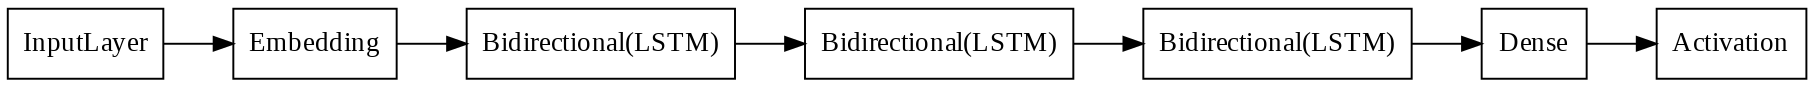

In [ ]:
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/BLSTM/model_plot.png', show_shapes=False, show_layer_names=False,rankdir='LR', expand_nested=False, dpi=140)

`Exécution `

In [ ]:
model=bidirectional_lstm_em_dt1(train_padded,voc_size)
model,history=lstm_fit(model,train_padded,y_train)
result=lstm_evaluation(model,test_padded,y_test)
model.save_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_chemssou_DT1/BLSTM/blstm_weights.h5")
save_pickle(result,"/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_chemssou_DT1/BLSTM/blstm_result.h5")
np.save('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_chemssou_DT1/BLSTM/blstm_history.npy',history.history)

# CNN

**Encodage WE.**

In [ ]:
#meilleure architecture CNN pour le corpus DT_2
def cnn_model_em_dt2(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] 
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
    model = Flatten()(concatenated_tensor)

    model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

#meilleure architecture CNN pour le corpus DT_3
def cnn_model_em_dt3(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] 
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
    model = Flatten()(concatenated_tensor)

    model = Dense(50, activation=act)(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

#meilleure architecture CNN pour le corpus DT_4
def cnn_model_em_dt4(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] 
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
    model = Flatten()(concatenated_tensor)

    model = Dropout(drop)(model)

    model = Dense(2, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

#meilleure architecture CNN pour le corpus DT_1
def cnn_model_em_dt1(train_padded,voc_size,act):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)

    model = Flatten()(maxpool_0)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

# apprentissage du modèle
def cnn_fit(model,train_padded,y_train):
  # fit network
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

# evaluation du modèle
def cnn_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)  
  print('loss:', result[0])   
  print('Accuracy:', result[1])   
  print('Fmeasure:', result[2])   
  print('precision:', result[3])  
  print('rappel:', result[4])   
  return result


`Exécution`

In [ ]:
model,history=cnn_fit(model,train_padded,y_train)
result=cnn_evaluation(model,test_padded,y_test)
model.save_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/chemssou_DT3/CNN/cnn_weights.h5")
save_pickle(result,"/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/chemssou_DT3/CNN/cnn_result.h5")
np.save("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_DT2/BLSTM/blstm_history.npy",history.history)

# CNN-BLSTM

**Encodage WE.**

In [ ]:
#meilleure architecture CNN-BLSTM pour le corpus DT_1

def cnn_blstm_dt1(train_padded,voc_size,act='tanh'):
    #train_padded,test_padded,voc_size=one_hot_encoding(x_train,x_test,max_words,2000)
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)

    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)

    model = maxpool_0

    model = Bidirectional(LSTM(20,dropout=0.5))(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model


#meilleure architecture CNN-BLSTM pour le corpus DT_2
def cnn_blstm_dt2(train_padded,voc_size,act='relu'):
    #train_padded,test_padded,voc_size=one_hot_encoding(x_train,x_test,max_words,2000)
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] # 20
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(embedding)


    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    model = concatenated_tensor

    model = Bidirectional(LSTM(30,dropout=0.5))(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

#meilleure architecture CNN-BLSTM pour le corpus DT_3
def cnn_blstm_dt3(train_padded,voc_size,act='relu'):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] 
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(embedding)


    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    model = concatenated_tensor

    model = Bidirectional(LSTM(30,dropout=0.5))(model)
    model = Dropout(drop)(model)

    model = Dense(3, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

#meilleure architecture CNN-BLSTM pour le corpus DT_4
def cnn_blstm_dt4(train_padded,voc_size,act='relu'):
    vocabulary_size = voc_size
    embedding_dim = 100
    num_filters = 32
    drop = 0.5
    sequence_length = train_padded.shape[1] 
    inp = Input(shape=(sequence_length,))

    embedding = Embedding(input_dim=voc_size,
                  output_dim=embedding_dim
                            )(inp)

    conv_0 = Conv1D(num_filters, kernel_size=2, padding='valid', activation=act)(embedding)
    conv_1 = Conv1D(num_filters, kernel_size=3, padding='valid', activation=act)(embedding)
    conv_2 = Conv1D(num_filters, kernel_size=4, padding='valid', activation=act)(embedding)


    maxpool_0 = MaxPooling1D(pool_size=2)(conv_0)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    maxpool_2 = MaxPooling1D(pool_size=2)(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    model = concatenated_tensor

    model = Bidirectional(LSTM(30,dropout=0.5))(model)
    model = Dropout(drop)(model)

    model = Dense(2, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)

    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])
    return model


# apprentissage du modèle
def cnn_blstm_fit(model,train_padded,y_train):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

# evaluation du modèle
def cnn_blstm_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)  
  print('loss:', result[0])   
  print('Accuracy:', result[1])   
  print('Fmeasure:', result[2])   
  print('precision:', result[3])   
  print('rappel:', result[4])   
  return result

`Exécution`

In [ ]:
model=cnn_blstm_dt4(train_padded,voc_size,'relu')
model,history=cnn_blstm_fit(model,train_padded,y_train)
result=cnn_blstm_evaluation(model,test_padded,y_test)

model.save_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/CNN_BLSTM/cnn_weights.h5")
save_pickle(result,"/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/CNN_BLSTM/cnn_result.h5")
np.save('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/CNN_BLSTM/cnn_history.npy',history.history)

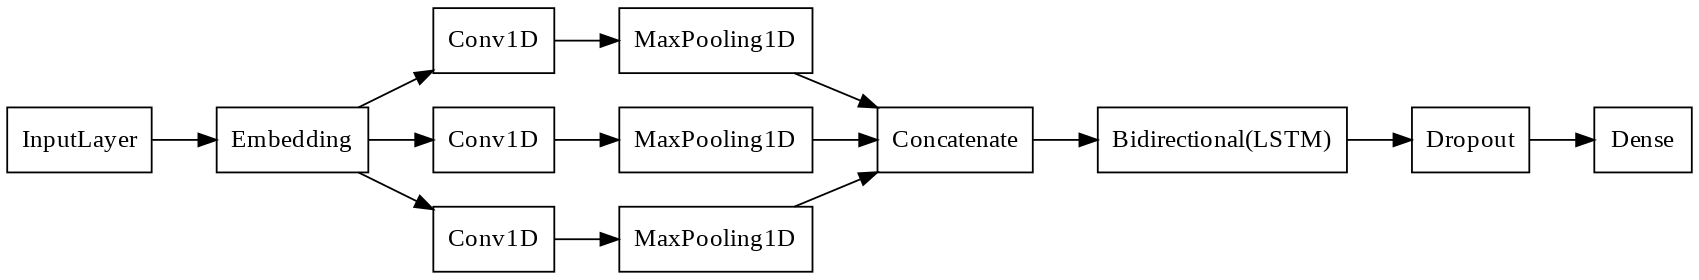

In [ ]:
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/CNN/model_plot.png', show_shapes=False, show_layer_names=False,rankdir='LR', expand_nested=False, dpi=130)

# MLP

**Encodage BOW.**

In [ ]:
#meilleure architecture MLP pour le corpus DT_1
def mlp_model_bow_dt1(train_padded,act):
    sequence_length = train_padded.shape[1] 

    model = Sequential()
    model.add(Dense(80, input_shape = (train_padded.shape[1], )))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(80, kernel_initializer='he_normal'))
    model.add(Activation(act))    
    model.add(Dropout(0.5))
    model.add(Dense(80, kernel_initializer='he_normal'))
    model.add(Activation(act))    
    model.add(Dropout(0.5))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

#meilleure architecture MLP pour le corpus DT_2
def mlp_model_bow_dt2(train_padded,act):

    model = Sequential()
    model.add(Dense(80, input_shape = (train_padded.shape[1], )))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(80, kernel_initializer='he_normal'))
    model.add(Activation(act))    
    model.add(Dropout(0.5))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

#meilleure architecture MLP pour le corpus DT_3
def mlp_model_bow_dt3(train_padded,act):

    model = Sequential()
    model.add(Dense(80, input_shape = (train_padded.shape[1], )))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(80, kernel_initializer='he_normal'))
    model.add(Activation(act))    
    model.add(Dropout(0.5))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

#meilleure architecture MLP pour le corpus DT_4
def mlp_model_bow_dt4(train_padded,act):

    model = Sequential()
    model.add(Dense(80, input_shape = (train_padded.shape[1], )))
    model.add(Activation(act))
    model.add(Dropout(0.5))
    model.add(Dense(80, kernel_initializer='he_normal'))
    model.add(Activation(act))    
    model.add(Dropout(0.5))
    model.add(Dense(3, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy',f1_m,precision_m, recall_m])    
    return model

# apprentissage du modèle
def mlp_fit(model,train_padded,y_train):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
  history = model.fit(train_padded, y_train, batch_size=100, epochs=20, verbose=1, validation_split=0.10,callbacks=[callback])  # starts training
  plot_graphs(history, "accuracy"),plot_graphs(history, "loss")
  return model,history

# evaluation du modèle
def mlp_evaluation(model,test_padded,y_test):
  result = model.evaluate(x=test_padded, y= y_test)   
  print('loss:', result[0])   
  print('Accuracy:', result[1])   
  print('Fmeasure:', result[2])   
  print('precision:', result[3])   
  print('rappel:', result[4])   
  return result

`MLP bow`

**Exécution**

In [ ]:
model=mlp_model_bow_dt4(train_bow,'tanh')
model,history=mlp_fit(model,train_bow,y_train)
result=mlp_evaluation(model,test_bow,y_test)
model.save_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/MLP/mlp_weights.h5")
save_pickle(result,"/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/MLP/mlp_result.h5")
np.save('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/historique/mataoui_2classes_DT4/MLP/mlp_history.npy',history.history)

# LOAD BEST MODELS WITH GHRAPHS AND EVALUATIONS

# DT_1: mataoui+chemssou

`LOAD BEST MODELS `

In [ ]:
train_padded_dt1=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/encodé/train_padded_dt1.pickle")
train_padded_dt2=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/encodé/train_padded_dt2.pickle")
train_padded_dt3=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/encodé/train_padded_dt3.pickle")

voc_size_1=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/encodé/voc_size_1.pickle")
voc_size_2=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/encodé/voc_size_2.pickle")
voc_size_3=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/dataset finale/Donné trouvé/encodé/voc_size_3.pickle")

**BLSTM**

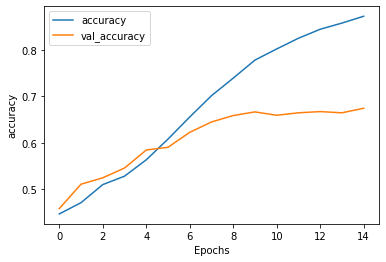

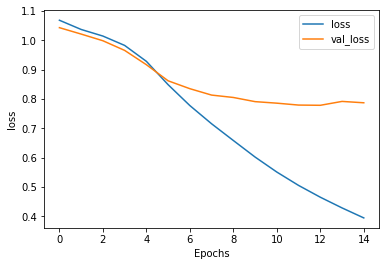

loss: 0.7583330869674683
Accuracy: 0.6912632584571838
Fmeasure: 0.6807231307029724
precision: 0.7619086503982544
rappel: 0.6170204281806946


In [ ]:
dt1_blstm=bidirectional_lstm_em_dt1(train_padded_dt1,voc_size_1)
dt1_blstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/BLSTM/blstm_weights_8.h5")
result_blstm_1=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/BLSTM/blstm_result_8.h5")
hisotry_blstm_1=history=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/BLSTM/blstm_history_8.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_blstm_1,'accuracy')
plot_graphs(hisotry_blstm_1,'loss')
print_metriques(result_blstm_1)

**CNN-BLSTM**

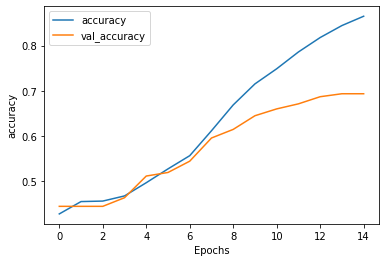

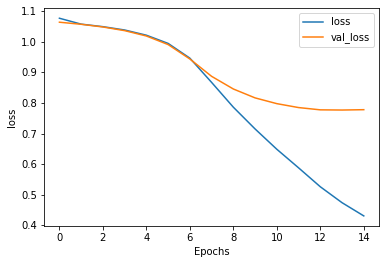

loss: 0.7907114028930664
Accuracy: 0.6853600740432739
Fmeasure: 0.6554222106933594
precision: 0.7384873628616333
rappel: 0.5904088020324707


In [ ]:
dt1_cnnblstm=cnn_blstm_dt1(train_padded_dt1,voc_size_1,'tanh')
dt1_cnnblstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/CNN_BLSTM/cnnblstm_weights_7.h5")
result_cnnblstm_1=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/CNN_BLSTM/cnnblstm_result_7.h5")
hisotry_cnnblstm_1=history=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/CNN_BLSTM/cnnblstm_history_7.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_cnnblstm_1,'accuracy')
plot_graphs(hisotry_cnnblstm_1,'loss')
print_metriques(result_cnnblstm_1)


**CNN**

In [ ]:
dt1_cnn=cnn_model_em_dt1(train_padded_dt1,voc_size_1,'tanh')
dt1_cnn.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/CNN/cnn_weights_8.h5")
result_cnn_1=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/CNN/cnn_result_8.h5")
hisotry_cnn_1=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_chemssou_DT1/CNN/cnn_history_8.h5")
print_metriques(result_cnn_1)


loss: 0.781173586845398
Accuracy: 0.6841794848442078
Fmeasure: 0.652898907661438
precision: 0.7535573244094849
rappel: 0.5786556601524353


# DT_2 : Mataoui

`LOAD BEST MODELS `

**BLSTM**

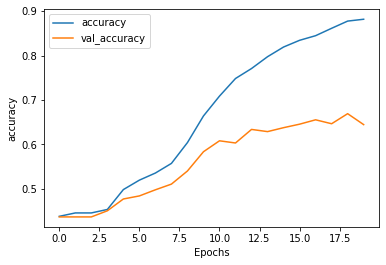

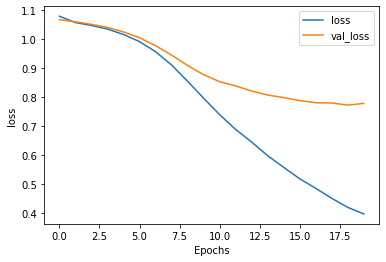

loss: 0.7263150215148926
Accuracy: 0.6932623982429504
Fmeasure: 0.6608355045318604
precision: 0.7506226301193237
rappel: 0.5928819179534912


In [ ]:
dt2_blstm=bidirectional_lstm_em_dt2(train_padded_dt2,voc_size_2)
dt2_blstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/BLSTM/blstm_weights_1.h5")
result_blstm_2=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/BLSTM/blstm_result_1.h5")
hisotry_blstm_2=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/BLSTM/blstm_history_1.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_blstm_2,'accuracy')
plot_graphs(hisotry_blstm_2,'loss')
print_metriques(result_blstm_2)

**CNN-BLSTM**

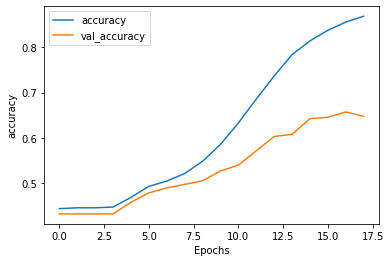

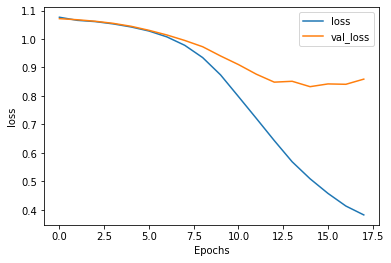

loss: 0.8005438446998596
Accuracy: 0.692375898361206
Fmeasure: 0.6659916043281555
precision: 0.7466214299201965
rappel: 0.6032986044883728


In [ ]:
dt2_cnnblstm=cnn_blstm_dt2(train_padded_dt2,voc_size_2,'relu')
dt2_cnnblstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/CNN_BLSTM/cnnblstm_weights_8.h5")
result_cnnblstm_2=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/CNN_BLSTM/cnnblstm_result_8.h5")
hisotry_cnnblstm_2=history=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/CNN_BLSTM/cnnblstm_history_8.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_cnnblstm_2,'accuracy')
plot_graphs(hisotry_cnnblstm_2,'loss')
print_metriques(result_cnnblstm_2)


**MLP**

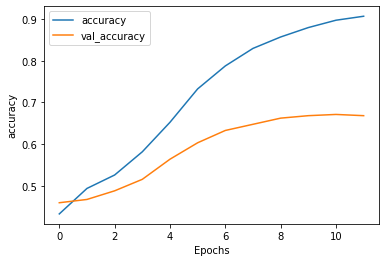

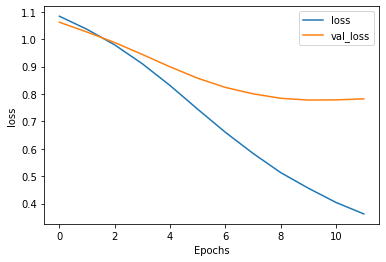

loss: 0.7338598370552063
Accuracy: 0.7065602540969849
Fmeasure: 0.6608784198760986
precision: 0.7626774311065674
rappel: 0.5850694179534912


In [ ]:
dt2_mlp=mlp_model_bow_dt2(train_bow,'tanh')
dt2_mlp.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/MLP/mlp_weights_1.h5")
result_mlp_2=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/MLP/mlp_result_1.h5")
hisotry_mlp_2=history=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/MLP/mlp_history_1.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_mlp_2,'accuracy')
plot_graphs(hisotry_mlp_2,'loss')
print_metriques(result_mlp_2)

**CNN**

In [ ]:
dt2_cnn=cnn_model_em_dt2(train_padded_dt2,voc_size_2,'relu')
dt2_cnn.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/CNN/cnn_weights_5.h5")
result_cnn_2=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_DT2/CNN/cnn_result_5.h5")
print_metriques(result_cnn_2)


loss: 0.7793680429458618
Accuracy: 0.6808510422706604
Fmeasure: 0.6728562712669373
precision: 0.7363135814666748
rappel: 0.6206597089767456


# DT_3 : Chemssou

`LOAD BEST MODELS `

**BLSTM**

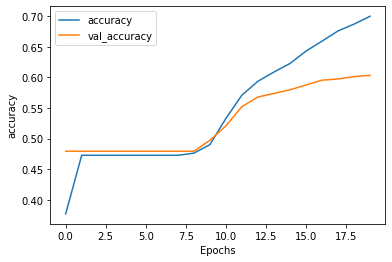

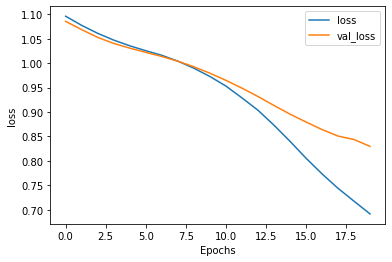

loss: 0.840302050113678
Accuracy: 0.6254416704177856
Fmeasure: 0.5680224895477295
precision: 0.7319549322128296
rappel: 0.46780306100845337


In [ ]:
dt3_blstm=bidirectional_lstm_em_dt3(train_padded_dt3,voc_size_3)
dt3_blstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/BLSTM/blstm_weights10.h5")
result_blstm_3=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/BLSTM/blstm_result10.h5")
hisotry_blstm_3=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/BLSTM/blstm_history10.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_blstm_3,'accuracy')
plot_graphs(hisotry_blstm_3,'loss')
print_metriques(result_blstm_3)

**CNN-BLSTM**

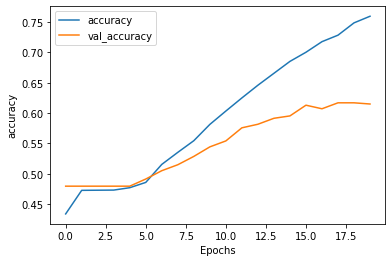

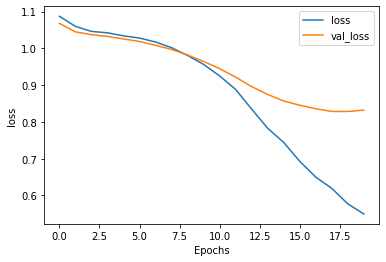

loss: 0.8316415548324585
Accuracy: 0.6183745861053467
Fmeasure: 0.6124992370605469
precision: 0.6960164904594421
rappel: 0.549400269985199


In [ ]:
dt3_cnnblstm=cnn_blstm_dt3(train_padded_dt3,voc_size_3,'relu')
dt3_cnnblstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/CNN_BLSTM/cnnblstm_weights_10.h5")
result_cnnblstm_3=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/CNN_BLSTM/cnnblstm_result_10.h5")
hisotry_cnnblstm_3=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/CNN_BLSTM/cnnblstm_history_10.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_cnnblstm_3,'accuracy')
plot_graphs(hisotry_cnnblstm_3,'loss')
print_metriques(result_cnnblstm_3)


**MLP**

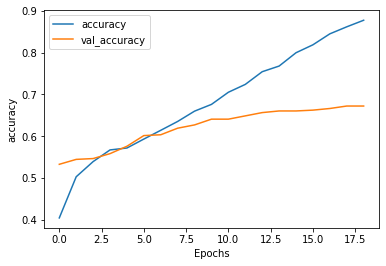

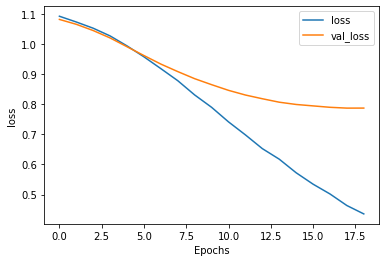

loss: 0.8138103485107422
Accuracy: 0.6537102460861206
Fmeasure: 0.5984434485435486
precision: 0.7224864959716797
rappel: 0.5140467286109924


In [ ]:
dt3_mlp=mlp_model_bow_dt3(train_bow,'relu')
dt3_mlp.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/MLP/mlp_weights_2.h5")
result_mlp_4=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/MLP/mlp_result_2.h5")
hisotry_mlp_4=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/MLP/mlp_history_2.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_mlp_4,'accuracy')
plot_graphs(hisotry_mlp_4,'loss')
print_metriques(result_mlp_4)

**CNN**

In [ ]:
dt3_cnn=cnn_model_em_dt3(train_padded_dt3,voc_size_3,'relu')
dt3_cnn.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/CNN/cnn_weights_7.h5")
result_cnn_3=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best chemssou_DT3/CNN/cnn_result_7.h5")
print_metriques(result_cnn_3)

loss: 0.8742790818214417
Accuracy: 0.6007066965103149
Fmeasure: 0.5730859041213989
precision: 0.6650517582893372
rappel: 0.5052083134651184


# DT_4

`LOAD BEST MODELS `

**BLSTM**

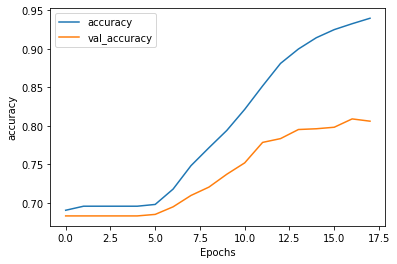

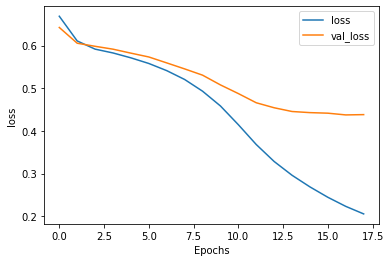

loss: 0.4061550498008728
Accuracy: 0.8226950168609619
Fmeasure: 0.8234540820121765
precision: 0.8249047994613647
rappel: 0.8220486044883728


In [ ]:
dt4_blstm=bidirectional_lstm_em_dt4(train_padded,voc_size)
dt4_blstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/BLSTM/blstm_weights1.h5")
result_blstm_4=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/BLSTM/blstm_result1.h5")
hisotry_blstm_4=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/BLSTM/blstm_history1.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_blstm_4,'accuracy')
plot_graphs(hisotry_blstm_4,'loss')
print_metriques(result_blstm_4)

**CNN-BLSTM**

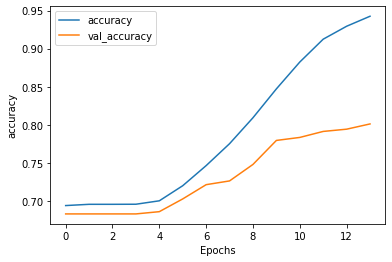

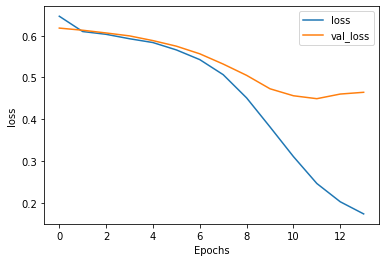

loss: 0.42373743653297424
Accuracy: 0.8191489577293396
Fmeasure: 0.8229166269302368
precision: 0.8229166865348816
rappel: 0.8229166865348816


In [ ]:
dt4_cnnblstm=cnn_blstm_dt4(train_padded,voc_size,'relu')
dt4_cnnblstm.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/CNN_BLSTM/cnnblstm_weights_1.h5")
result_cnnblstm_4=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/CNN_BLSTM/cnnblstm_result_1.h5")
hisotry_cnnblstm_4=np.load('/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/CNN_BLSTM/cnnblstm_history_1.npy',allow_pickle='TRUE').item()
plot_graphs(hisotry_cnnblstm_4,'accuracy')
plot_graphs(hisotry_cnnblstm_4,'loss')
print_metriques(result_cnnblstm_4)

**CNN**

In [ ]:
dt4_cnn=cnn_model_em_dt4(train_padded,voc_size,'relu')
dt4_cnn.load_weights("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/CNN/cnn_weights_1.h5")
result_cnn_4=open_pickle("/content/drive/My Drive/PROJET FIN ETUDE 2019 2020/Modèle finale/best mataoui_2classes_DT4/CNN/cnn_result_1.h5")
print_metriques(result_cnn_4)

loss: 0.4145543873310089
Accuracy: 0.8280141949653625
Fmeasure: 0.832984209060669
precision: 0.8326689600944519
rappel: 0.8333333134651184


# Stacking

In [ ]:
pip install deepstack

In [ ]:
from deepstack.base import KerasMember

member1 = KerasMember(name="dt1_cnn", keras_model=dt1_cnn, train_batches=(train_padded, y_train), val_batches=(test_padded, y_test))
member2 = KerasMember(name="dt1_blstm", keras_model=dt1_blstm, train_batches=(train_padded, y_train), val_batches=(test_padded, y_test))
member3 = KerasMember(name="dt1_cnnblstm", keras_model=dt1_cnnblstm, train_batches=(train_padded, y_train), val_batches=(test_padded, y_test))


In [ ]:
from deepstack.ensemble import StackEnsemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

stack = StackEnsemble()
stack.model = RandomForestRegressor(verbose=0, n_estimators=200, 
                                  max_depth=15, n_jobs=80, min_samples_split=200)
stack.add_members([member1, member2, member3])
stack.fit()
stack.describe(metric = accuracy_score)

Calling predict
dt1_cnn - accuracy_score: 0.8589
dt1_blstm - accuracy_score: 0.8725
dt1_cnnblstm - accuracy_score: 0.8660
StackEnsemble accuracy_score: 0.8955


0.8955135773317592